# Bayesian inference

1. Unified approach to probabilistic model inference using Bayes theorem:

$$
p(model | data)\sim p(data | model)\cdot p(model)
$$

e.g. for the linear regression $y=wx$ or $y\sim {\cal N}(w x,\sigma^2)$:

$$
p(w|data)\sim p(data|w)p(w)
$$

2 Accounting for any prior theoretic of empirical knownledge expressed through $p(model)$:

* reasonable range or theoretic distribution for the model parameters
* fitted the model over previous data sample, now refining the estimate with a large or more recent one 
* some general guideline, like not having the magnitide of the coefficients too high (Ridge, Lasso)
* uninformed prior (uniform with equal probabilities or defined over the broad range, like normal with high variance)

Implementation: 
* simulation of the model with different parameters sampled from prior
* assessing the likelihood of the data given the model
* adjusting the likelihood of parameters to posteriors $p(model | data)$ according to Bayes theorem

Challenges: 
* computational: simulation of multiple samples for complex multinomial priors
* analytic: posterior distribution might be empirically assessed but have no closed form analytic expression

## Bayesian linear regression

## Example 1. Simple univariate regression - real-estate price prediction

Consider an example of predicting prices of individual homes $y$ vs their sizes $x$:
$$
y=w x+\varepsilon,
$$
given a series of single-dimensional observations $D=\{(y_i,x_i), i=1..N\}$, where $w$ is the slope coefficient to fit (in our case - average price of the square foot) and $\epsilon$ is the error term (deviation of the specific price from the predicted value), assuming that 
$$
\varepsilon\sim {\cal N}(0,\sigma^2).
$$
As we remember ordinary least square (OLS) estimate in the univariate case gives a simple estimate $\hat{w}$ for the slope coefficient $w$:
$$
\hat{w}=\frac{\sum_i y_i x_i}{\sum_i x_i^2}.
$$
After we get $w=\hat{w}$ it is easy to estimate the standard error 
$$
\sigma=\sqrt{\frac{\sum_i (y_i-\hat{w} x_i)^2}{N}}.
$$

In [1]:
!pip install arviz==0.6.1
!pip install pymc3==3.5
!pip install Theano==1.0.4

     |████████████████████████████████| 1.4MB 5.1MB/s 
     |████████████████████████████████| 4.7MB 16.2MB/s 
     |████████████████████████████████| 317kB 40.8MB/s 
     |████████████████████████████████| 1.3MB 4.3MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7
     |████████████████████████████████| 2.8MB 4.6MB/s 
  Created wheel for Theano: filename=Theano-1.0.4-cp37-none-any.whl size=2667178 sha256=bbd9f4611dc84795dbd9bccc11b436fffd2f3cfc3c68da006c603ca38c4cbe2b
  Stored in directory: /root/.cache/pip/wheels/88/fb/be/483910ff7e9f703f30a10605ad7605f3316493875c86637014
Successfully built Theano
  Found existing installation: Theano 1.0.5
    Uninstalling Theano-1.0.5:
      Successfully uninstalled Theano-1.0.5


In [2]:
import numpy as np
import pandas as pd
%pylab inline
import matplotlib.pyplot as plt
#import Quandl
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
# from pandas.stats.api import ols
from sklearn import linear_model
import seaborn as sns
import theano

# PyMC3 for Bayesian Inference
import pymc3 as pm
import arviz

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
pylab.rcParams['figure.figsize'] = [12,8]

In [4]:
#read real estate sample data
REsample1 = pd.read_csv('https://raw.githubusercontent.com/CUSP2021ADS/Data/main/REsample1.csv')
REsample1.head()

,Unnamed: 0,borough,neighborhood,building_class_category,tax_class_present,block,lot,easement,building_class_present,address,apartment_number,zip_code,residential_units,commmercial_units,total_units,land_sq_feet,gross_sq_feet,year_built,tax_class_time_sale,build_class_time_sale,sale_price,sale_date,serialid,sale_year,sale_month
0,5631,3,BAY RIDGE,01 ONE FAMILY HOMES,1,5871,91,NaN,A5,24 BAY RIDGE PLACE,NaN,11209,1,0,1,1600,1400,1910,1,A5,585000.0,2009-10-29,5631,9,9
1,5635,3,BAY RIDGE,01 ONE FAMILY HOMES,1,5882,38,NaN,A5,7014 LOUISE TERRACE,NaN,11209,1,0,1,1169,1224,1925,1,A5,515000.0,2009-10-15,5635,9,9
2,5636,3,BAY RIDGE,01 ONE FAMILY HOMES,1,5882,50,NaN,A5,7009 LOUISE TERRACE,NaN,11209,1,0,1,945,1836,1925,1,A5,499900.0,2009-04-20,5636,9,3
3,5637,3,BAY RIDGE,01 ONE FAMILY HOMES,1,5882,80,NaN,A5,7002 COLONIAL ROAD,NaN,11209,1,0,1,1121,1330,1925,1,A5,525000.0,2009-09-02,5637,9,8
4,5638,3,BAY RIDGE,01 ONE FAMILY HOMES,1,5882,81,NaN,A5,7004 COLONIAL ROAD,NaN,11209,1,0,1,1118,1224,1925,1,A5,400000.0,2009-07-24,5638,9,6


In [5]:
#first fit the regression for the entire sample
RE1w=sum(REsample1.sale_price*REsample1.gross_sq_feet)/sum(REsample1.gross_sq_feet**2)
#estimate the standard error sigma
sigma=np.std(REsample1.sale_price-REsample1.gross_sq_feet*RE1w)
print('Estimated w={0}, sigma={1}'.format(RE1w,sigma))

Estimated w=423.2627749191691, sigma=387363.5777545546


In [6]:
REsample1.shape

(309, 25)

In [7]:
#now redo the regression for just the first 100 records
REsample11=REsample1.loc[0:99]
RE11w=sum(REsample11.sale_price*REsample11.gross_sq_feet)/sum(REsample11.gross_sq_feet**2)
print('Estimated w={0}'.format(RE11w))

Estimated w=369.71390461235694


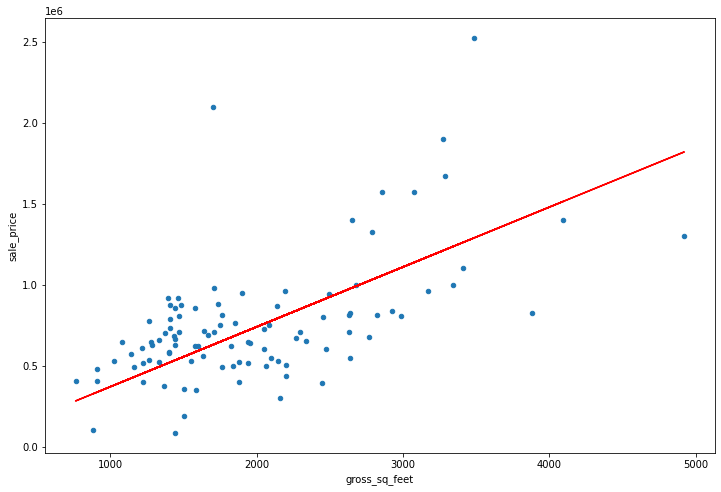

In [8]:
#visualize the fit
REsample11.plot(kind='scatter',x='gross_sq_feet',y='sale_price')
y1=RE11w*REsample11.gross_sq_feet
plt.plot(REsample11.gross_sq_feet,y1,'r-')

We see quite a deviation in the estimates $\hat{w}$ obtained - so the OLS estimate depends on the sample choice and uses to vary from one sample to another. So for any particular choice of the training sample there is no guarantee that the estimate $\hat{w}$ is indeed a true value for $w$ - we should admit uncertainty in our estimate, which OLS does not really allow to make, but the further Bayesian framework will.

# Bayesian univariate regression

Also imagine that we already have certain prior knowledge about $w$ for example this would be the case if we already studied some sample of house prices before. Can we take this into account somehow? The prior knowledge can be expressed through a prior distribution $p(w)$.

Consider a probabilistic version of a univariate regression:
$$
y\sim {\cal N}(w x,\sigma^2),
$$
assuming that the variance $\sigma^2$ is given or at least independent on $w$ and the only real-valued single dimensional coefficient to estimate based on a series of single-dimensional observations $D=(Y,X)=\{(y_i,x_i), i=1..N\}$ is $w$. In a similar manner as we just did for fitting a normal distribution, each single observation changes a given conjugate normal prior
$$
w\sim {\cal N}(w^*,\sigma^*)
$$
to a posterior
$$
p(w|y=y_i, x=x_i)\sim p(y=y_i|w,x=x_i)p(w)\sim e^{-\frac{(y_i-w x_i)^2}{2\sigma^2}-\frac{(w-w^*)^2}{2(\sigma^*)^2}}\sim
$$$$
\sim e^{-w^2 \frac{x_i^2(\sigma^*)^2+\sigma^2}{2\sigma^2(\sigma^*)^2}+w \frac{(\sigma^*)^2 y_i x_i+\sigma^2 w^*}{2\sigma^2(\sigma^*)^2}}
\sim e^{\frac{\left(w-\frac{ \sigma^{-2} y_i x_i +(\sigma^*)^{-2} w^*}{ \left(x_i^2\sigma^{-2}+(\sigma^*)^{-2}\right)}\right)^2}{\frac{2 }{(\sigma^*)^{-2}+x_i^2\sigma^{-2}}}}
$$
so posterior distribution is also normal.


In order to add all the observations from $D$ one can either iterate the above process or consider a single equation based on a multi-variable probability distribution, which is easy to handle assuming that different observations are independent:
$$
p(w|Y, X)\sim p(Y|w,X)p(w)=p(w)\prod\limits_i p(y=y_i|w,x=x_i)\sim e^{-\sum\limits_i \frac{(y_i-w x_i)^2}{2\sigma^2}-\frac{(w-w^*)^2}{2(\sigma^*)^2}}=e^{-\frac{RSS(w)}{2\sigma^2}-\frac{(w-w^*)^2}{2(\sigma^*)^2}}\hspace{5ex} (1)
$$
If one needs a specific estimate $\hat{w}$ for $w$ then it could be found as the most probable value from
$$
\hat{w}=argmax_w p(w|Y, X)=argmin_w\left[\frac{RSS(w)}{2\sigma^2}+\frac{(w-w^*)^2}{2(\sigma^*)^2}\right]\hspace{5ex} (2)
$$

$$
p(w|Y, X)\sim e^{-w^2 \frac{\sum_i x_i^2(\sigma^*)^2+\sigma^2}{2\sigma^2(\sigma^*)^2}+w \frac{(\sigma^*)^2 \sum_i y_i x_i+\sigma^2 w^*}{2\sigma^2(\sigma^*)^2}}\sim e^{\frac{\left(w-\frac{ \sigma^{-2} \sum_i y_i x_i +(\sigma^*)^{-2} w^*}{\left(\sum_i x_i^2\sigma^{-2}+(\sigma^*)^{-2}\right)}\right)^2}{\frac{2}{(\sigma^*)^{-2}+\sum_i x_i^2\sigma^{-2}}}}\sim
$$

$$
\sim {\cal N}\left(\frac{ \sigma^{-2} \sum_i y_i x_i +(\sigma^*)^{-2} w^*}{\left(\sum_i x_i^2\sigma^{-2}+(\sigma^*)^{-2}\right)},
\frac{1}{\sqrt{(\sigma^*)^{-2}+\sum_i x_i^2\sigma^{-2}}}\right)
$$

### Uninformed prior

In case of an unfinformed prior with $\sigma^*\to \infty$ the above estimate (2) is tends to be equivalent to the one given by the regular OLS, i.e. to
$$
RSS(w)\to \min
$$
However in addition to the single best fit slope coefficient estimate (2), Bayesian regression also provides an entire probabilistic normal distribution
$$
w\sim {\cal N}\left(\frac{\sum_i x_i y_i}{\sum_i x_i^2},\frac{\sigma}{\sqrt{\sum_i x_i^2}}\right)
$$
for the possible values of $w$, being able to explain from the rigorous probabilistic standpoint the meaning behind the confidence intervals and hypothesis testing.

One point here is that so far we consider $\sigma$ as given. There is a more sophisticated Bayesian framework which allows to estimate it together with $w$ (conceptually just enough to consider a vector of two latent variables $w,\sigma$ instead of $w$ and specify its joint prior distribution, although maths is much heavier in that case). For now we can simply rely on the streightforward max-likelihood estimate
$$
\hat{\sigma}^2=\frac{RSS(\hat{w})}{N}
$$
also being an actual sample standard deviation of the set of observed prediction errors for the optimal $w=\hat{w}$.

## Example 1 revisited. Distribution for the sq.foot price

In [9]:
# assess the distibution of the parameter for the entire sample
#we already have the estimate, just need to select sigma here using formulas above- take the one we estimated for the entire sample
RE11s=sigma/(sum(REsample11.gross_sq_feet**2)**0.5)

In [10]:
print('w ~ N({0},{1})'.format(RE11w,RE11s))

w ~ N(369.71390461235694,18.29352380197333)


notice that the standard deviation we found for $w$ depends on the choice of $\sigma$ and might become different if we take $\sigma$ based on the considered subsample rather than the entire sample as we did.

## Example 2. Bayesian regression example - tuning the houses price regression trained above

Now if say we have the results of the previos estimate (but not retain the training data anymore) and later find more training data to consider, we can further adjust the former estimate through the above Bayesian framework.

In [11]:
#consider the remaining part of the housing prices data separately
REsample12=REsample1.loc[100:]
#and compute the OLS estimate
RE12w0=sum(REsample12.sale_price*REsample12.gross_sq_feet)/sum(REsample12.gross_sq_feet**2)
print('Estimated w={0}'.format(RE12w0))

Estimated w=450.92131889689307


In [12]:
#now implement Bayesian regression starting from the prior obtained based on the first sample w ~ N(369.713904612,18.293523802)
RE12w0=sum(REsample12.sale_price*REsample12.gross_sq_feet)/sum(REsample12.gross_sq_feet**2)
s22=sigma**-2; s12=RE11s**-2
RE12w=(s22*sum(REsample12.sale_price*REsample12.gross_sq_feet)+s12*RE11w)/(s22*sum(REsample12.gross_sq_feet**2)+s12)
RE12s=(s22*sum(REsample12.gross_sq_feet**2)+s12)**(-0.5)
print('w ~ N({0},{1})'.format(RE12w,RE12s))

w ~ N(423.2627749191691,10.676138164724133)


This is already pretty consistend with what python will give us if we take the entire training sample at once

In [13]:
lm = smf.ols(formula='sale_price ~ gross_sq_feet -1', data = REsample1).fit()
print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:             sale_price   R-squared (uncentered):                   0.835
Model:                            OLS   Adj. R-squared (uncentered):              0.835
Method:                 Least Squares   F-statistic:                              1562.
Date:                Tue, 30 Mar 2021   Prob (F-statistic):                   1.13e-122
Time:                        17:02:27   Log-Likelihood:                         -4414.8
No. Observations:                 309   AIC:                                      8832.
Df Residuals:                     308   BIC:                                      8835.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

So Bayesian framework allows to efficiently utilize prior knowledge on the regression parameters to be estimated and also provides us not just with one single best estimate for them but with the entire distribution for the possible value, admitting uncertainty. 

Let's also give some intuition of how strongly the prior knowledge affects the result compared to the new knowledge obtained from the training sample. Clearly if the prior knowledge is obtained from just a few observations while the further sample considered is pretty big, the result should be dominated by the further observations with little impact of the prior. But it seems that there is no information about how big the initial sample was... However this is not actually the case! 

The key here is the deviation we have in the prior distribution - the fewer data was used to generate the prior estimate, the more uncertain it will be (higher deviation) and the smaller will be its impact on the posterior. For example uninformed prior having variance going to infinity, tends to have no impact on the result. On the other hand, a very narrow prior means that it has been obtained based on a very strong evidence and should have a major impact on the posterior despite further observations. So all necessary information is already in the prior - when we combine prior estimate based on one sample and with the further observations from the second sample, the first sample size is somehow "encoded" in the prior variance and all the necessary information is already there.

# Multivariate case and regularization

Now consider a multivatiate linear regression model
$$
y\sim {\cal N}(w^T x,\sigma^2).
$$
Again assume that $\sigma$ is known or independent on $w$, while for the components of the vector $w=(w_1,w_2,...w_n)$ the prior distributions are known to be pairwise independent normal distributions
$$
w_j\sim{\cal N}(w_j^*,\sigma_j^*).
$$

$$
p(w|Y,X)\sim p(Y|w,X)p(w)=p(w)\prod\limits_i p(y=y_i|w,x=x_i)p(w)=\prod_i p(y=y_i|w,x=x_i)\prod_j p(w_j)\sim 
$$
$$
\sim\prod\limits_i e^{\frac{-(y_i-w^T x_i)^2}{2\sigma^2}}\prod\limits_j e^{-\frac{(w_j-w_j^*)^2}{2(\sigma_i^*)^2}}=e^{-\frac{RSS(w)}{2\sigma^2}-\sum\limits_j \frac{(w_j-w_j^*)^2}{2(\sigma_i^*)^2}},
$$

so the estimate for the best fit $\hat{w}$ could be found from
$$
\hat{w}=argmax_w p(w|Y, X)=argmin_w\left[\frac{RSS(w)}{\sigma^2}+\sum\limits_j\frac{(w_j-w_j^*)^2}{(\sigma_j^*)^2}\right]\hspace{5ex}
$$

An important particular case of all the components of $w$ having the same prior $w_j\sim{\cal N}(0,\sigma/\sqrt{\lambda})$ leads to

$$
\hat{w}=argmin_w\left[RSS(w)+\lambda||w||_2^2\right]\hspace{5ex}(3)
$$

where $||w||_2=\sqrt{\sum\limits_j w_j^2}$, known as Ridge regression.

An alternative choice of the Laplacian prior distribution $p(w_j)\sim e^{-\lambda|w_j|/\sigma}$ leads to  
$$
\hat{w}=argmin_w\left[RSS(w)+\lambda||w||_1\right],\hspace{5ex}(4)
$$
where $||w||_1=\sum\limits_j |w_j|$, known as Lasso (least absolute shrinkage and selection operator) regression.

Both Ridge and Lasso could be shown to be equivalent to a constrained minimization of $RSS$:

$$
RSS(w)\to min, \ ||w||_p\leq \alpha,\hspace{5ex}(5)
$$

with $p=1,2$ respectively, although analytic relation between constants $\alpha$ and $\lambda$ is somewhat nontrivial. In practice however the choice of $\lambda$ or $\alpha$ is usually empirical anyway, so both regularized (i.e. (3)-(4) with adding a regularization term ||w||) or constrained forms (5) of the optimization problem are equally applicable.

Optimization problems (3) and (4) tend to minimize $RSS$ at the same time penalizing the regression for having $||w||$ too large (regularization) which often leads to the model complexity through multiple regressors with large coefficients canceling effect of each other. So in a sense Lasso and Ridge are trying to avoid this situation, looking for relatively simple "regular" models with best possible fit. 

Their Bayesian derivation show that Lasso and Ridge simply perform the regression with the prior belief that all the components of the $w$ are limited through the fixed variance of the priors. Such a belief affects the final outcome of the model making solutions with large $||w||$ to be particularly unlikely.

This helps Ridge and Lasso to fight overfitting also dealing with multicollinearity of regressors to some extent, preventing from learning noise through particularly complex "unnatural" combinations of the regressors.

Ridge regression admits solution in the closed form (consider partial derivatives of the objective function with respect to $w_j$):

$$
\hat{w}=(X^T X+\lambda I)^{-1}X^T Y, \hspace{5ex} (6)
$$

where $I$ is the identity $n\times n$ matrix, while $n$ being the number of regressors. The formulae (6) shows that the Ridge regression can in theory deal with the case of multicollinearity, when the matrix $X^T X$ is singular and OLS estimate does not exist.

Lasso does not admit solution in the closed form and requires numerical methods (like subgradient methods) to be fit. 
Lasso however has an advantage of being able to completely eliminate impact of certain irrelevant regressors setting the corresponding slope coefficients to zero.  

So the ability of the model to predict future values of $y$ depends (besides the irreducible error which we're not in control of) on both - the variance in our estimae of $\hat{w}$ as well as the bias in our estimation (i.e. systematic shift like under or overestimation) of the true values of $w$ and $y$. 

The OLS estimate in theory is known to be unbiased (tends to have zero bias provided that the training sample is large enough), however might have pretty high variance in $\hat{w}$ especially when the regressors are highly correlated. This reduces its generalizeability. Regularized regression, like Ridge and Lasso can introduce some bias (might not fit the training sample that well), but may largely reduce variance by limiting the $||w||$ (and become much less sensitive to small changes in the training data, reducing the risk of overfitting).

Generally, often the more complex model able to better learn from the training sample (lower bias) have higher variance, which leads to overfitting and high error for predicting the future values of the output variable.

## Estimating probability distributions through Markov Chain Monte Carlo (MCMC) simulation

Unlike the frequestist approach, the Bayesian approach provides a rigorous way to make probability statements about different variables in question. The approach is to summarize the entire posterior probability distribution, which is necessary to make probabilistic statements about real quantities of interest for data scientists. 

This undertaking is achieved through Markov Chain Monte Carlo (MCMC) simulation, and we will now show a popular MCMC algorithm (Gibbs algorithm) using the bivariate normal distribution.

We'll use the Gibbs sampler to simulate a joint normal distribution for two variables with known covariance. Gibb's sampler draws iteratively from posterior conditional distributions for each variable. Thus, essentially, we simulate the bivariate normal distribution by iteratively sampling values from conditional distributions of variables. Finally, we estimate the mean and covariance of the distribution obtained from Gibbs sampler.


Let's first demonstrate a theoretic bivariate normal distribution with unit variance

Text(0.5, 0.92, 'Bivariate Normal')

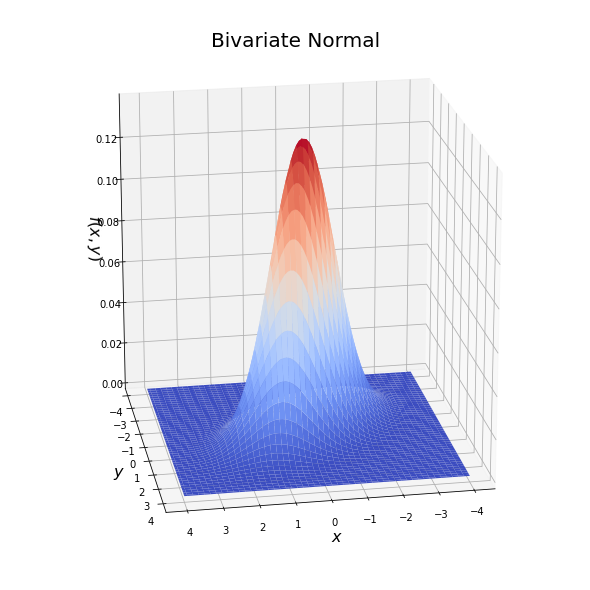

In [14]:
# joint bivariate normal distribution

import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

x, y = np.linspace(-4, 4, 100), np.linspace(-4, 4, 100)
x, y = np.meshgrid(x, y)
z = np.mat(np.zeros(2))
p = np.zeros(np.shape(x))
R = np.matrix([[1, 0.5],[0.5, 1]]) # assign covariance as 0.5 between x, y
Rinv = linalg.inv(R)

for i in range(len(x)):
    for j in range(len(y)):
        z[0, 0] = x[i, j]
        z[0, 1] = y[i, j]
        p[i, j] = (1.0 / (2 * np.pi) * np.sqrt(linalg.det(R))) * np.exp(-(z * Rinv *z.T) / 2)

fig = plt.figure(figsize = (8, 8))
ax = Axes3D(fig)
#ax.plot_wireframe(x, y, p, rstride=3, cstride=3, color='#AD5300')
ax.plot_surface(x, y, p, rstride=2, cstride=2, cmap=cm.coolwarm, shade='interp')
#ax.plot_wireframe(x, y, p, rstride=3, cstride=3, color='black')
ax.view_init(20, 80) # rotation through 20, 40, 60, 80
ax.set_xlabel(r'$x$', fontsize = 16)
ax.set_ylabel(r'$y$', fontsize = 16)
ax.set_zlabel(r'$f(x, y)$', fontsize = 16)
ax.set_title(r'Bivariate Normal', fontsize = 20)

#### Notes

* The bluer the region, the less likely is it.  The redder the region, the more likely it is.
* Same can be observed in the contour slices of the distribution

Text(0.5, 1.0, 'Contour Slices of Bivariate Normal')

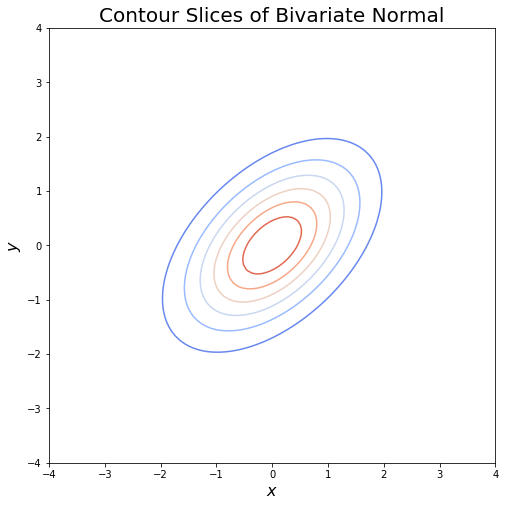

In [15]:
# contour plot
fig = plt.figure(figsize = (8, 8))
ax = fig.gca()
ax.contour(x, y, p, cmap=cm.coolwarm)  
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_xlabel(r'$x$', fontsize = 16)
ax.set_ylabel(r'$y$', fontsize = 16)
ax.set_title(r'Contour Slices of Bivariate Normal', fontsize = 20)

## MCMC Simulation Using The Gibbs Algorithm 


* The Gibbs algorithm is a Markov chain Monte Carlo (MCMC) method to simulate a sequence of observations, as an approximation, when direct sampling is difficult. Direct sampling is complex in cases where joint distribution is not known explicitly. These cases generally arise when a particular parameter's prior is not conjugate with that parameter's likelihood (i.e. the posterior distribution does not belong to the same distribution family as the prior, i.e. normal posterior following normal prior), which could make estimation of distribution of posterior difficult and computationally intracable (e.g. no closed form analytic expression for the posterior).


#### The Gibbs algorithm steps:

The Gibbs sampler works by restructuring the joint estimation problem as a series of smaller, easier estimation problems. For example, consider the case where the parameter vector can be represented as: $\theta' = [\theta_{1}'\text{ }\theta_{2}']$, with joint distribution $p(\theta_{1}, \theta_{2})$

The bivariate general Gibbs Sampler  can be broken down into simple steps:

1. Set up sampler specifications including the number of iterations and the number of burn-ins draws (initial interations not used in final sampling but just to warm up the algorithm).
2. Choose a starting value $\theta_1^{(r)}$ with $r:=0$
3. Draw $\theta_2^{(r+1)}$ from $\:p(\theta_2|\:\theta_1^{(r)})$
4. Draw $\theta_1^{(r+1)}$ from $\:p(\theta_1|\:\theta_2^{(r+1)})$
5. Repeat 3-4 for desired number of iterations.
6. Final calculations including means, standard deviations and plots.



* The sequence geneated by this method can be used to approximate through historgrams:

    1. a joint distribution
    2. a marginal distribution of one of the variables
    3. an integral to be used to generate averages

* It is a simple method that makes use of random numbers that generates a Markov chain. 
* We need time for the Markov chain to converge to reasonable numbers, referred to as the "Burn In". 

Now we will initiate Gibbs algorithm to simulate the contour slices of a bivariate normal with $\rho = 0.5$. (covariance)

* Start the MCMC chain at an arbitrary starting value (-10, -10).
* Our results are not dependent on this artibrary starting value.
* In the code below, mc is the number of mcmc replications.
* start is the random starting point, (start, start).

In [16]:
mc = 10000 
start = -10

x = np.zeros(mc)
y = np.zeros(mc)  
x[0], y[0] = start, start

for i in range(2, mc): 
    x[i] = np.random.normal(loc = 0.5 * y[i-1], scale = np.sqrt(1 - 0.5 * 0.5), size=1) 
    y[i] = np.random.normal(loc = 0.5 * x[i], scale = np.sqrt(1- 0.5 * 0.5), size=1)

#### Notes
* We start the MCMC chain at an arbitrary point and follow its progression by connecting all the simulated points with a line.
* We want to see the simulated point "build up" throughout the support of the bivariate normal.

Text(0.5, 1.0, 'First 50 Iterations of Gibbs Algorithm')

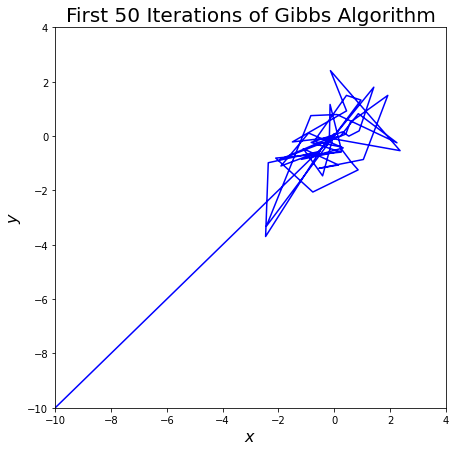

In [17]:
plt.figure(figsize = (7, 7))
plt.plot(x[0:49], y[0:49], 'b')
plt.xlim(-10,4)
plt.ylim(-10,4)
plt.xlabel(r'$x$', fontsize = 16)
plt.ylabel(r'$y$', fontsize = 16)
plt.title(r'First 50 Iterations of Gibbs Algorithm', fontsize = 20)

Text(0.5, 1.0, 'First 500 Iterations of Gibbs Algorithm')

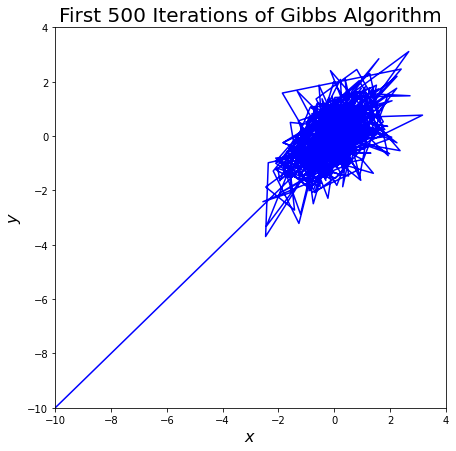

In [18]:
plt.figure(figsize = (7, 7))
plt.plot(x[0:499], y[0:499], 'b')
plt.xlim(-10,4)
plt.ylim(-10,4)
plt.xlabel(r'$x$', fontsize = 16)
plt.ylabel(r'$y$', fontsize = 16)
plt.title(r'First 500 Iterations of Gibbs Algorithm', fontsize = 20)

Text(0.5, 1.0, 'First 1,000 Iterations of Gibbs Algorithm')

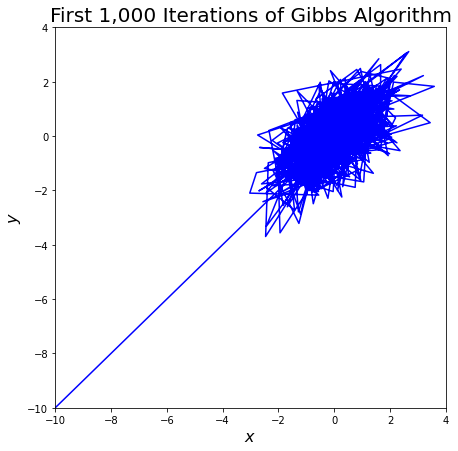

In [19]:
plt.figure(figsize = (7,7))
plt.plot(x[0:999], y[0:999], 'b')
plt.xlim(-10,4)
plt.ylim(-10,4)
plt.xlabel(r'$x$', fontsize = 16)
plt.ylabel(r'$y$', fontsize = 16)
plt.title(r'First 1,000 Iterations of Gibbs Algorithm', fontsize = 20)

#### Notes

* Treat the first 500 MCMC replications as the burn in and discard them.
* Generate a scatterplot of the remaining replications.
* Keeping in mind the bivariate normal, notice what is important in these MCMC replications.
    1. Their coverage is dense where the bivariate normal is most probable.
    2. It is sparse where the bivariate normal is the least probable.
* This is the the key to simulating a distribution function using MCMC.

Text(0.5, 1.0, 'Scatterplot of Gibbs Algorithm After Burn-In: Joint Distribution')

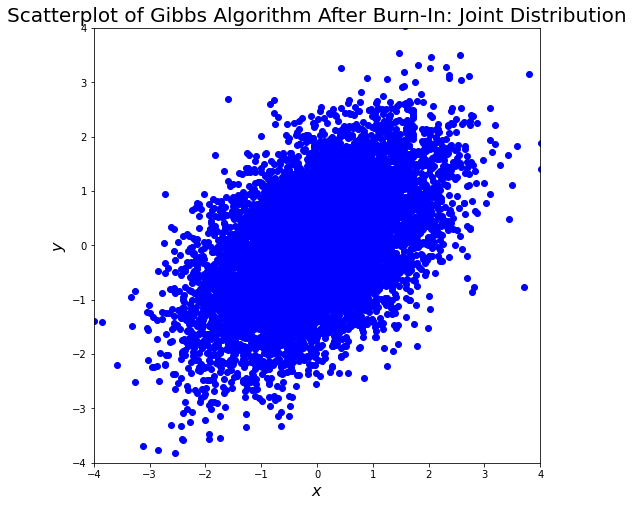

In [20]:
plt.figure(figsize = (8,8))
plt.scatter(x[499:9999], y[499:9999], c='b')
plt.xlim(-4, 4)
plt.ylim(-4 ,4)
plt.xlabel(r'$x$', fontsize = 16)
plt.ylabel(r'$y$', fontsize = 16)
plt.title(r'Scatterplot of Gibbs Algorithm After Burn-In: Joint Distribution', fontsize = 20)

#### Notes

* Having simulated the bivariate normal with the Gibbs algorithm, we can examine to key aspects discussed above. Calculate the average posterior together with 95% credible interval.
* We have basically recreated the univariate normal with mean zero and variance one.

The average is -0.006514
The 2.5 and 97.5 percentiles are -2.046172 and 2.031121


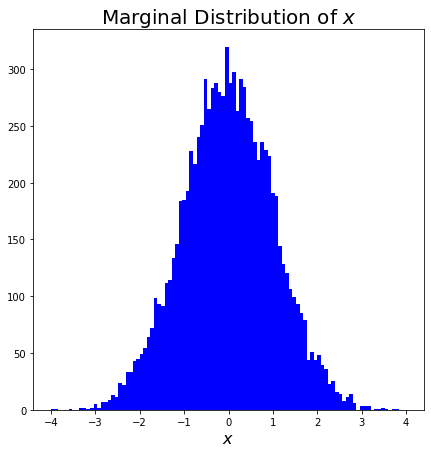

In [21]:
plt.figure(figsize = (7,7))
plt.hist(x[499:9999], bins=100, range=(-4, 4), color='b')
plt.xlabel(r'$x$', fontsize = 16)
plt.title(r'Marginal Distribution of $x$', fontsize = 20)

mean = x[499:9999].mean()
p2 = np.percentile(x[499:9999], 2.5)
p97 = np.percentile(x[499:9999], 97.5)
print("The average is %f" % mean)
print("The 2.5 and 97.5 percentiles are %f and %f" % (p2, p97))

The average is -0.003635
The 2.5 and 97.5 percentiles are -2.006367 and 1.983430


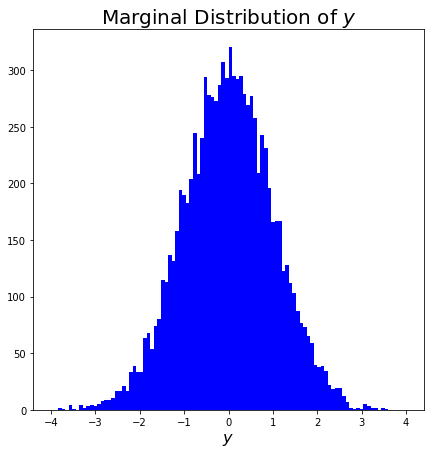

In [22]:
plt.figure(figsize = (7,7))
plt.hist(y[499:9999], bins=100, range=(-4, 4), color='b')
plt.xlabel(r'$y$', fontsize = 16)
plt.title(r'Marginal Distribution of $y$', fontsize = 20)

mean = y[499:9999].mean()
p2, p97 = np.percentile(y[499:9999], 2.5), np.percentile(y[499:9999], 97.5)
print("The average is %f" % mean)
print("The 2.5 and 97.5 percentiles are %f and %f" % (p2, p97))

Using Gibb's sampling, we have estimated the joint distribution of x and y as well as their marginal distributions. Essentially, we have re-created the bivariate normal distribution described before through sampling x and y points iteratively from their conditional distributions, which is the essence of Gibb's sampling.

## Estimating distributions of coefficients in linear regression with MCMC sampling

We now show a regression case and estimate the posterior distributions of variable coefficients from the data.

Here we take information of multiple persons' body characteristics, their daily exercise duration (in minutes) and the corresponding calories burned by them duration the exercise. The body characteristics present in the data are: Gender, Age, Height (cm), Weight (kg), Heart Rate (bpm) and Body Temperature (celsius). Each person is reference by a unique ID (denoted by user_id). In total, we take 500 unique data points.

Along with the duration, body characteristics can play roles in the amount of calories a person burns during the exercise. We are interested in creating a linear model for estimating the amount of calories burned with the exercise duration and different body characteristics as predictors.

In [23]:
# read the data files

exercise = pd.read_csv('https://raw.githubusercontent.com/CUSP2021ADS/Data/main/exercise.csv')
calories = pd.read_csv('https://raw.githubusercontent.com/CUSP2021ADS/Data/main/calories.csv')
df = pd.merge(exercise, calories, on = 'User_ID')
df = df[df['Calories'] < 300]
df = df.sample(500, random_state=2002)
df = df.reset_index()
df.head()

,index,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,11600,12638994,female,25,173.0,69.0,29.0,117.0,41.0,207.0
1,8467,15045105,female,38,162.0,62.0,20.0,94.0,40.3,100.0
2,3719,15529573,male,29,178.0,81.0,28.0,106.0,40.9,167.0
3,14508,16230503,female,50,155.0,57.0,9.0,97.0,39.8,50.0
4,13061,16641757,male,28,181.0,80.0,19.0,105.0,40.2,109.0


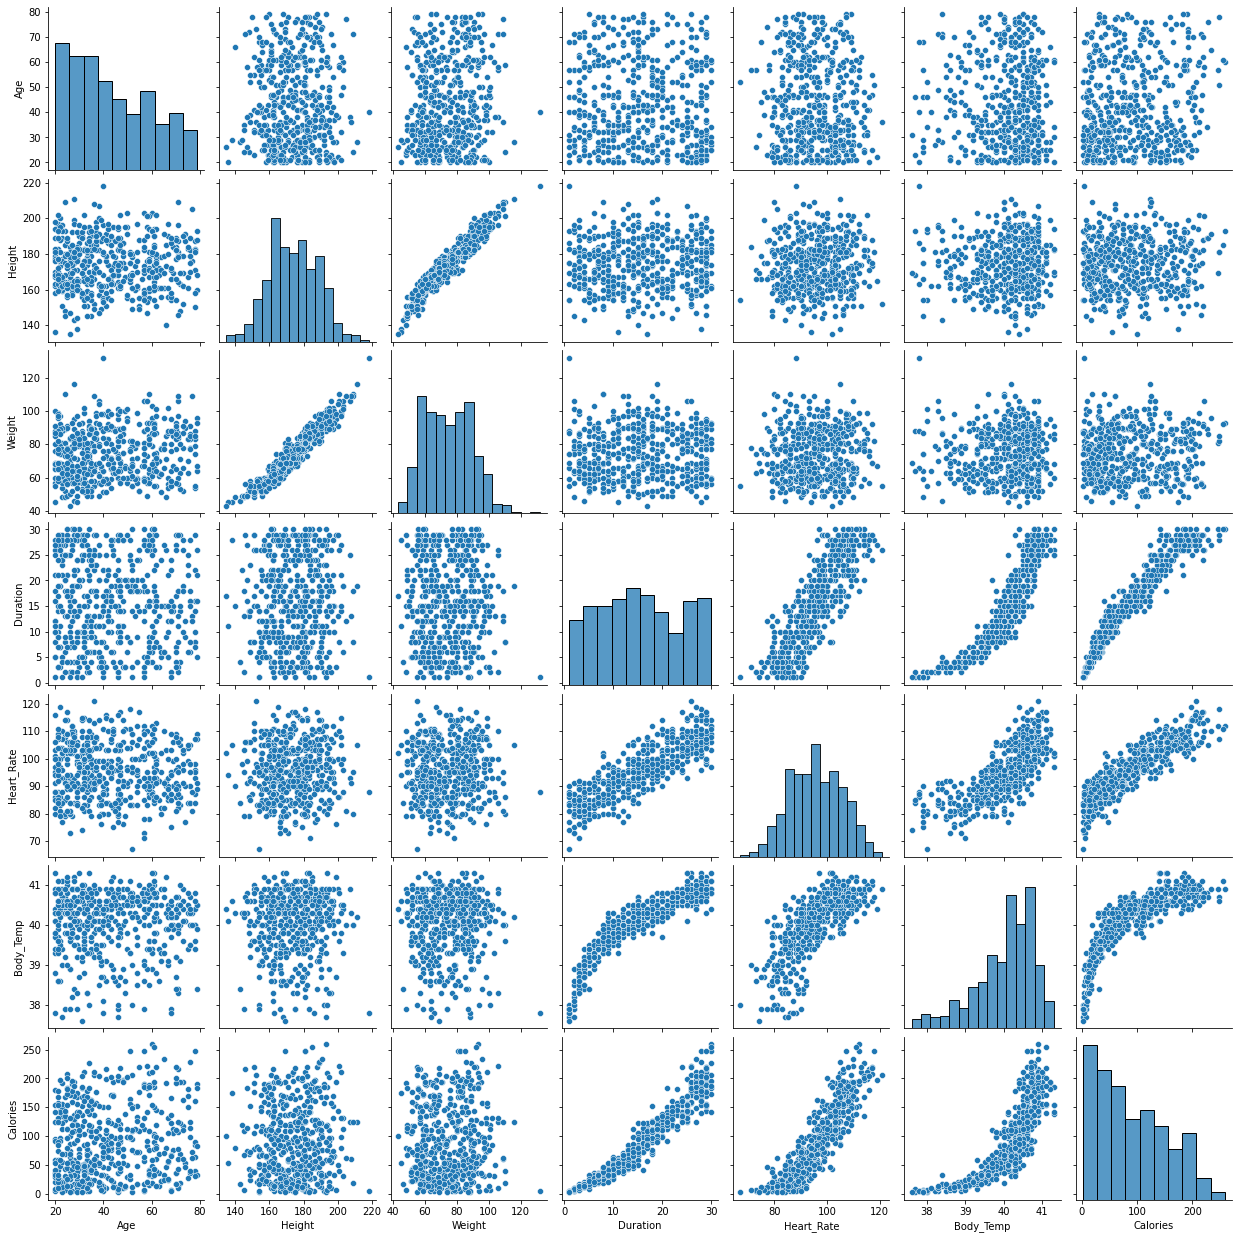

In [24]:
# exploratory scatter plot of continuous variables

sns.pairplot(df.iloc[:, 3:])


We are interested in predicting the amount of calories burned based on body characteristics and excercise duration as predictors. 

Let's first implement a univariate regression taking just one variable (excercise duration) and estimate the posterior distributions of coefficients. 

In [25]:
## univariate regression 

formula = 'Calories ~ ' + df.columns.values[6]
formula

'Calories ~ Duration'

## Initialize model parameters' prior distributions and estimate posterior distributions with MCMC simulations

We'll use PyMC3, a popular Python library for Bayesian inference with MCMC simulation. It allows to construct probabilistic models operating random variables with known prior distribution and estimate the posterior of the Bayesian inference.

In more specific terms, the formula for univariate regression is ŷ(x) = 𝛼 + 𝛽 · x , where 𝛼 is intercept and 𝛽 is slope coefficient - we'll introduce them as random variables to simulate using selected priors

We assume that the parameters are distributed in a certain way (priors). We take the intercept and slope (coefficient of 'duration' variable) are normally distributed; a slope averages around 7.5 (average calory burn per minute for average person with average excercise activity) and standard deviation of 5, for the intercept (calories in transition to/from the excercise) with mean 15 and a standard deviation of 5.

For the likelihood, we assume a normal distribution with a mean of ŷ(x) and a uniformly distributed standard deviation between 0 and 10.

In [26]:
with pm.Model() as linear_model:
    # Intercept prior
    intercept = pm.Normal('Intercept', mu = 15, sd = 5)
    
    # Slope prior
    slope = pm.Normal('slope', mu = 7.5, sd = 5)
    
    # Standard deviation prior
    sigma = pm.HalfNormal('sigma', sd = 10)
    
    # y_est is the specification of the Bayesian model (here linear regression) to be estimated.
    y_est = intercept + slope * df['Duration']
    
    # define likelihood
    likelihood = pm.Normal('Y_obs', mu = y_est, sd = sigma, observed = df['Calories'])
    
    # MCMC sampling
    # We use the Maximum a Posteriori (MAP) values as starting values for the MCMC sampling.
    start = pm.find_MAP()
    trace1 = pm.sample(1000, start=start, progressbar=True)

logp = -2,186.4, ||grad|| = 24.607: 100%|██████████| 27/27 [00:00<00:00, 821.74it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, slope, Intercept]
100%|██████████| 1500/1500 [00:02<00:00, 650.37it/s]


PyMc3 model functions details:

- find_MAP finds the starting point for the sampling algorithm by deriving the local maximum a posteriori point.
- NUTS implements the MCMC sampling algorithm given the assumed priors.
- sample draws a number of samples given the starting value from find_MAP and the optimal step size from the NUTS algorithm.

<Figure size 720x720 with 0 Axes>

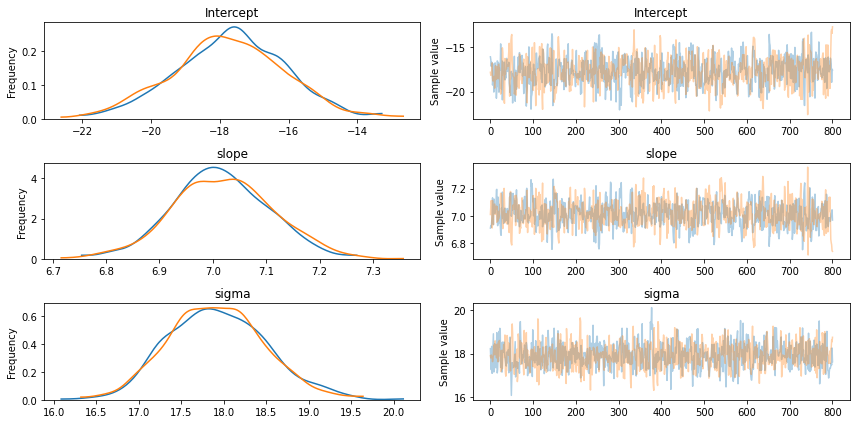

<Figure size 720x720 with 0 Axes>

In [27]:
# Show results after burn in of 200 MCMC replications.

fig = pm.traceplot(trace1[199:1000])
plt.figure(figsize = (10, 10))

In [28]:
# mean of slope
np.mean(trace1['slope'])

7.016206342475777

The left side of the traceplot is the marginal posterior distributions of model parameters: the values for the variable are on the x-axis with the probability for the variable (as determined by sampling) on the y-axis. The different colored lines indicate that we performed two chains of Markov Chain Monte Carlo. From the left side we can see that there is a range of values for each weight. The right side shows the different sample values drawn as the sampling process runs.

In [29]:
# let's try with narrow priors

with pm.Model() as linear_model:
    # Intercept prior
    intercept = pm.Normal('Intercept', mu = 15, sd = 2)
    
    # Slope prior
    slope = pm.Normal('slope', mu = 7.5, sd = 2)
    
    # Standard deviation prior
    sigma = pm.HalfNormal('sigma', sd = 10)
    
    # y_est is the specification of the Bayesian model (here linear regression) to be estimated.
    y_est = intercept + slope * df['Duration']
    
    # define likelihood
    likelihood = pm.Normal('Y_obs', mu = y_est, sd = sigma, observed = df['Calories'])
    
    # MCMC sampling
    # We use the Maximum a Posteriori (MAP) values as starting values for the MCMC sampling.
    start = pm.find_MAP()
    trace2 = pm.sample(1000, start=start, progressbar=True)

logp = -2,271.8, ||grad|| = 192.52: 100%|██████████| 27/27 [00:00<00:00, 914.83it/s]   
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, slope, Intercept]
100%|██████████| 1500/1500 [00:01<00:00, 805.11it/s]


<Figure size 720x720 with 0 Axes>

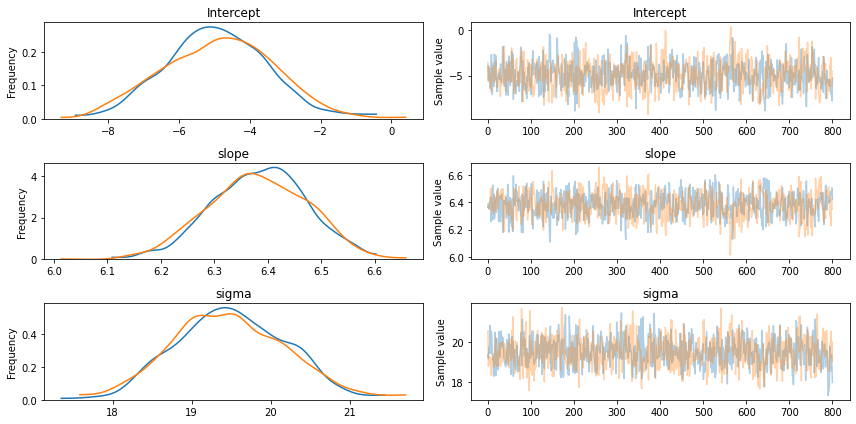

<Figure size 720x720 with 0 Axes>

In [30]:
# Show results after burn in of 200 MCMC replications.

fig = pm.traceplot(trace2[199:1000])
plt.figure(figsize = (10, 10))

In [31]:
# check mean of slope
np.mean(trace2['slope'])

6.382207579842449

Notice the mean slope value changed

Let's try with a uniform parameter distribution with low=2 and high=15. It would signify that we know that we burn between 2 (sleep) and 15 (super intense workout) calories per minute.

In [32]:
with pm.Model() as linear_model:
    # Intercept prior
    intercept = pm.Normal('Intercept', mu = 15, sd = 2)
    
    # Slope prior
    slope = pm.Uniform('slope', lower=2, upper=15)
    
    # Standard deviation prior
    sigma = pm.HalfNormal('sigma', sd = 10)
    
    # y_est is the specification of the Bayesian model (here linear regression) to be estimated.
    y_est = intercept + slope * df['Duration']
    
    # define likelihood
    likelihood = pm.Normal('Y_obs', mu = y_est, sd = sigma, observed = df['Calories'])
    
    # MCMC sampling
    # We use the Maximum a Posteriori (MAP) values as starting values for the MCMC sampling.
    start = pm.find_MAP()
    trace3 = pm.sample(1000, start=start, progressbar=True)

logp = -2,253, ||grad|| = 4.1221: 100%|██████████| 25/25 [00:00<00:00, 1158.55it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, slope, Intercept]
100%|██████████| 1500/1500 [00:01<00:00, 771.51it/s]
The acceptance probability does not match the target. It is 0.8815778666580416, but should be close to 0.8. Try to increase the number of tuning steps.


<Figure size 720x720 with 0 Axes>

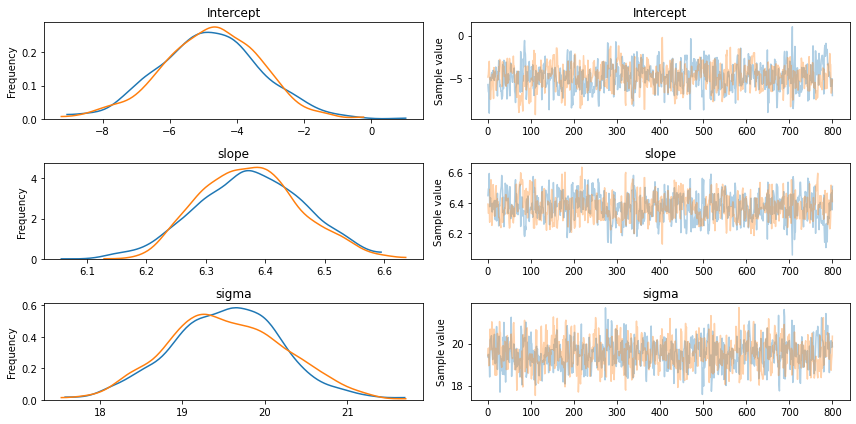

<Figure size 720x720 with 0 Axes>

In [33]:
# Show results after burn in of 200 MCMC replications.

fig = pm.traceplot(trace3[199:1000])
plt.figure(figsize = (10, 10))

In [34]:
np.mean(trace3['slope'])

6.372873760598266

Slope remained almost same before but sigma and slope parameters changed.

## plot posterior distributions of model parameters

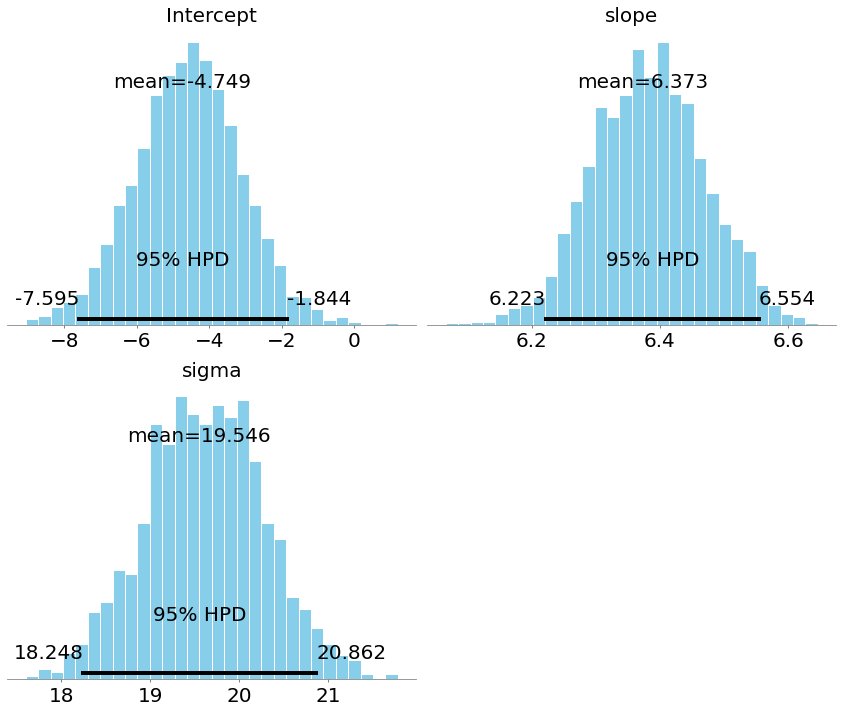

In [35]:
pm.plot_posterior(trace3, figsize = (12, 10), text_size = 20);

In [36]:
# check parameters with linear regression

X = sm.add_constant(np.array(df[['Duration']]))
y = np.array(df[['Calories']])
lr = sm.OLS(y, X).fit()
print('slope: ', lr.params[1], 'intercept: ', lr.params[0])
print('95% confidence interval: ', 'slope: ', lr.conf_int(alpha=0.05, cols=None)[1], 
      'intercept: ', lr.conf_int(alpha=0.05, cols=None)[0])

slope:  7.204627086367095 intercept:  -21.511456580708646
95% confidence interval:  slope:  [7.0185976  7.39065657] intercept:  [-24.81380216 -18.209111  ]


the parameters estimated by linear regression are roughly the same as mean of posterior distributions estimated from above with Normal priors and broad variance

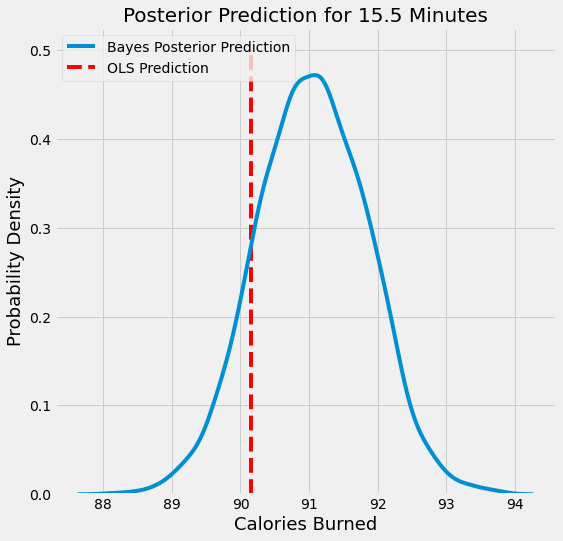

In [40]:
# posterior distribution for one data point (duration = 15.5 minutes)

bayes_prediction = trace1['Intercept'] + trace1['slope'] * 15.5
plt.figure(figsize = (8, 8))
plt.style.use('fivethirtyeight')
sns.kdeplot(bayes_prediction, label = 'Bayes Posterior Prediction')
plt.vlines(x = -21.511456580708646 + 7.204627086* 15.5, 
           ymin = 0, ymax = 0.5, 
           label = 'OLS Prediction',
          colors = 'red', linestyles='--')

plt.legend();
plt.xlabel('Calories Burned', size = 18), plt.ylabel('Probability Density', size = 18);
plt.title('Posterior Prediction for 15.5 Minutes', size = 20);

### How Do the Priors Affect the Posteriors?

Let's take a different set of priors and see how the posterior distributions change.

In the last case, we took "flat" priors for the parameters. Here, let's assume somewhat "narrow" normal distributions with standard deviation of 2 for intercept and slope.

Priors can be initialized based on different distributions. In case of normal distributions, flat priors (large std) usually implies no/little knowledge by us about the model parameters. Initializing flat priors means we don't want the posterior distributions be largely affected by our prior beliefs, allowing the posterior distributions to be driven mostly by obersved data. The opposite is true in case of narrow priors, which means we have strong assumptions about model parameters. For instance, if we have strong assumptions about the impact of exercise duration, the 'slope' coefficient prior should have a low std.

In [41]:
with pm.Model() as linear_model:
    # Intercept prior
    intercept = pm.Normal('Intercept', mu = 0, sd = 2)
    
    # Slope prior
    slope = pm.Normal('slope', mu = 0, sd = 2)
    
    # Standard deviation prior
    sigma = pm.HalfNormal('sigma', sd = 10)
    
    # y_est is the specification of the Bayesian model (here linear regression) to be estimated.
    y_est = intercept + slope * df['Duration']
    
    # define likelihood
    likelihood = pm.Normal('Y_obs', mu = y_est, sd = sigma, observed = df['Calories'])
    
    # MCMC sampling
    # We use the Maximum a Posteriori (MAP) values as starting values for the MCMC sampling.
    start = pm.find_MAP()
    trace = pm.sample(1000, start=start, progressbar=True)

logp = -2,200.6, ||grad|| = 72.5: 100%|██████████| 37/37 [00:00<00:00, 1212.88it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, slope, Intercept]
100%|██████████| 1500/1500 [00:01<00:00, 792.00it/s]


<Figure size 720x720 with 0 Axes>

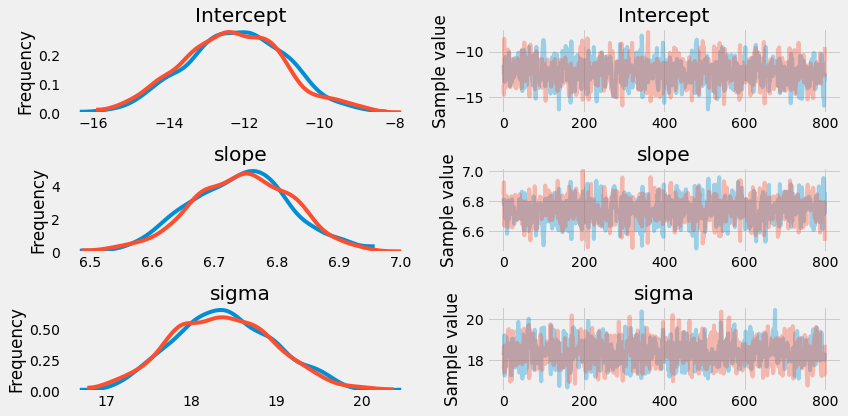

<Figure size 720x720 with 0 Axes>

In [42]:
# Show results after burn in of 200 MCMC replications.

fig = pm.traceplot(trace[199:1000])
plt.figure(figsize = (10, 10))

Observe that the distributions of parameters change somewhat here, demonstrating that posterior distributions are driven by both prior and observed data.

Note: "Narrow" priors usually correspond to strong set of prior beliefs about the data before even observing it. If we don't have any information/strong assumptions about the data, we usually take "flat" priors and let the estimation of distributions be dependent mostly on observed samples.

## Implement multivariate regression with MCMC sampling for above data 
Take 'Age, Height, Weight, Duration, Heart_Rate, Body_Temp' variables as regressors and 'calories' as target variabel. Plot the posterior distributions of model parameters.


In [43]:
## mutivariate regression

formula = 'Calories ~ ' + ' + '.join(['%s' % variable for variable in df.columns[3:-1]])
formula

'Calories ~ Age + Height + Weight + Duration + Heart_Rate + Body_Temp'

In [44]:
# posterior estimation with MCMC sampling

with pm.Model() as normal_model:
    
    # The prior for the model parameters
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta1 = pm.Normal('age', mu=0, sd=20) 
    beta2 = pm.Normal('height', mu=0, sd=20)
    beta3 = pm.Normal('weight', mu=0, sd=20)
    beta4 = pm.Normal('duration', mu=7.5, sd=3)
    beta5 = pm.Normal('heart rate', mu=0, sd=20)
    beta6 = pm.Normal('body temp', mu=0, sd=20)
    sigma = pm.HalfNormal('sigma', sd=10)
    
    # Creating the model requires a formula and data (and optionally a family)
    mean = alpha + beta1 * df['Age'] + beta2 * df['Height'] + beta3 * df['Weight'] + beta4 * df['Duration'] + beta5 * df['Heart_Rate'] + beta6 * df['Body_Temp']
    
    # Observed values
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = df['Calories'])
    
    # MCMC sampling
    # We use the Maximum a Posteriori (MAP) values as starting values for the MCMC sampling.
    start = pm.find_MAP()
    trace = pm.sample(1000, start=start, progressbar=True)

logp = -1,969.6, ||grad|| = 11.721: 100%|██████████| 93/93 [00:00<00:00, 959.43it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, body temp, heart rate, duration, weight, height, age, alpha]
100%|██████████| 1500/1500 [01:13<00:00, 20.33it/s]


<Figure size 720x720 with 0 Axes>

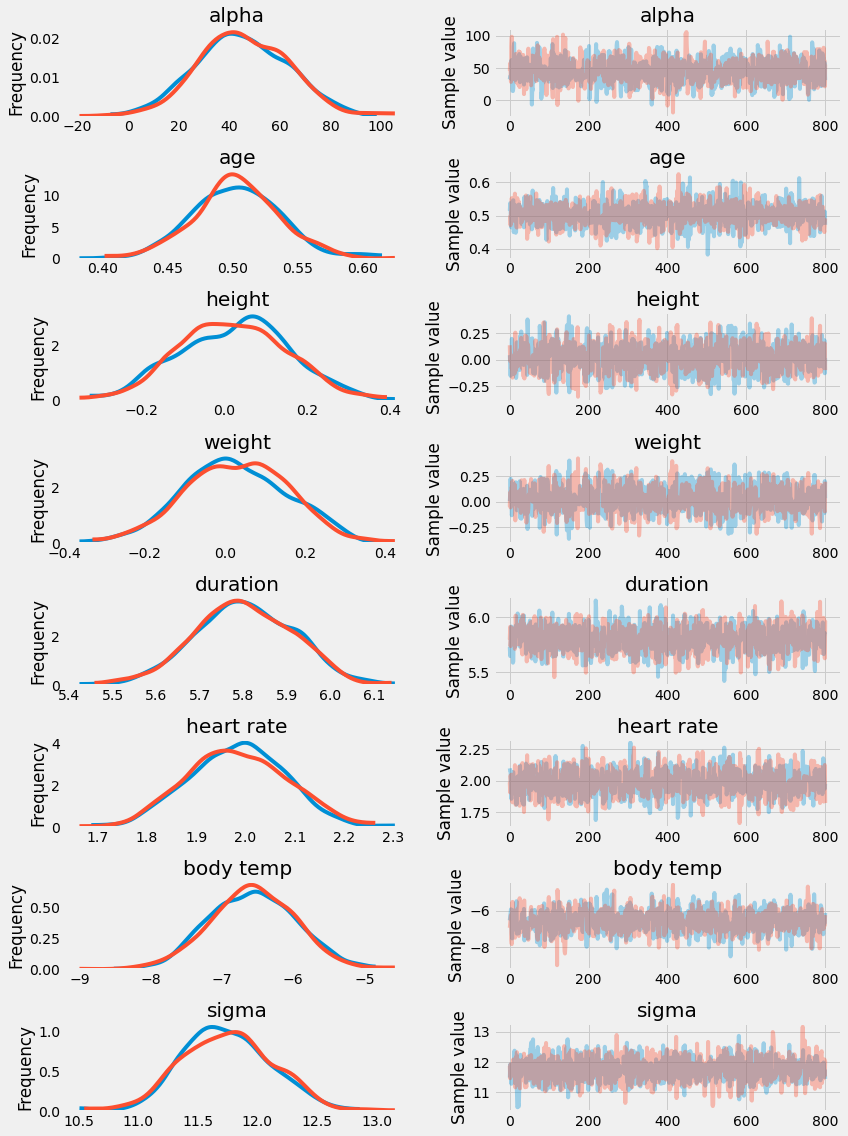

<Figure size 720x720 with 0 Axes>

In [45]:
fig = pm.traceplot(trace[199:1000])
plt.figure(figsize = (10, 10))

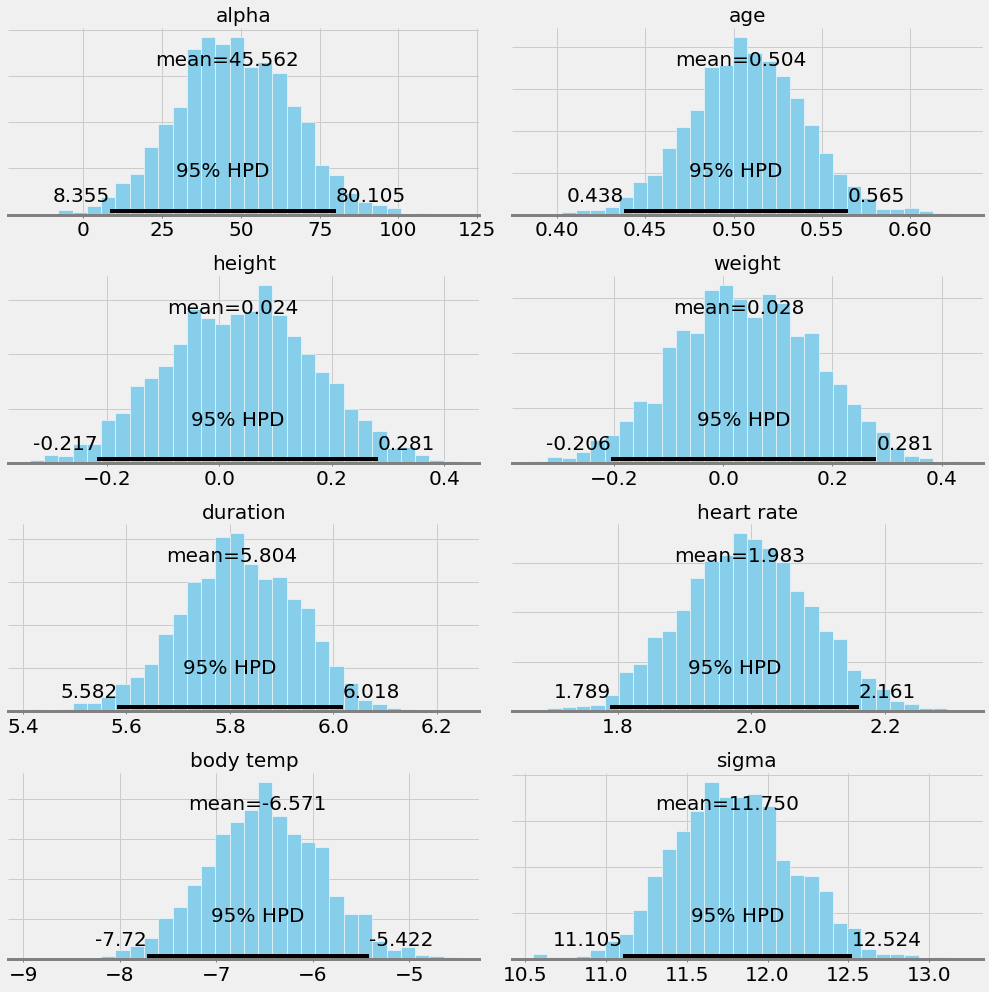

In [46]:
pm.plot_posterior(trace, figsize = (14, 14), text_size=20);

In [47]:
## Linear Formula from Bayesian Inference using Mean of Parameters

model_formula = 'Calories = '
for variable in trace.varnames:
    model_formula += ' %0.2f * %s +' % (np.mean(trace[variable]), variable)

' '.join(model_formula.split(' ')[:-1])

'Calories =  45.56 * alpha + 0.50 * age + 0.02 * height + 0.03 * weight + 5.80 * duration + 1.98 * heart rate + -6.57 * body temp + 2.46 * sigma_log__ + 11.75 * sigma'

## HW tasks

Take the house sale price data from the starting of the notebook and implement the following regressions over different set of priors.

1. 'sale_price ~ gross_sq_feet' (don't use the intercept term here, take sigma to be constant: 8000)
2. 'sale_price ~ gross_sq_feet + land_sq_feet + year_built'

Take reasonable set of priors for the variable coefficients:
different ranges, for example 100-300 for gross_sq_ft , 200-400, for land_sq_ft and 80-120 for year_built variables.
(don't use intercept and take sigma=8000)

Aslo compare each of the resulting distributions from above regressions with OLS regression outputs.

In [49]:
REsample1.head()

,Unnamed: 0,borough,neighborhood,building_class_category,tax_class_present,block,lot,easement,building_class_present,address,apartment_number,zip_code,residential_units,commmercial_units,total_units,land_sq_feet,gross_sq_feet,year_built,tax_class_time_sale,build_class_time_sale,sale_price,sale_date,serialid,sale_year,sale_month
0,5631,3,BAY RIDGE,01 ONE FAMILY HOMES,1,5871,91,NaN,A5,24 BAY RIDGE PLACE,NaN,11209,1,0,1,1600,1400,1910,1,A5,585000.0,2009-10-29,5631,9,9
1,5635,3,BAY RIDGE,01 ONE FAMILY HOMES,1,5882,38,NaN,A5,7014 LOUISE TERRACE,NaN,11209,1,0,1,1169,1224,1925,1,A5,515000.0,2009-10-15,5635,9,9
2,5636,3,BAY RIDGE,01 ONE FAMILY HOMES,1,5882,50,NaN,A5,7009 LOUISE TERRACE,NaN,11209,1,0,1,945,1836,1925,1,A5,499900.0,2009-04-20,5636,9,3
3,5637,3,BAY RIDGE,01 ONE FAMILY HOMES,1,5882,80,NaN,A5,7002 COLONIAL ROAD,NaN,11209,1,0,1,1121,1330,1925,1,A5,525000.0,2009-09-02,5637,9,8
4,5638,3,BAY RIDGE,01 ONE FAMILY HOMES,1,5882,81,NaN,A5,7004 COLONIAL ROAD,NaN,11209,1,0,1,1118,1224,1925,1,A5,400000.0,2009-07-24,5638,9,6


In [65]:
with pm.Model() as linear_model:
    
    # Slope prior
    slope = pm.Normal('slope_gross_SqFt', mu = 150, sd = 50)
    
    # Standard deviation prior
    sigma = 8000
    
    # y_est is the specification of the Bayesian model (here linear regression) to be estimated.
    y_est = slope * REsample1['gross_sq_feet']
    
    # define likelihood
    likelihood = pm.Normal('Y_obs', mu = y_est, sd = sigma, observed = REsample1['sale_price'])
    
    # MCMC sampling
    # We use the Maximum a Posteriori (MAP) values as starting values for the MCMC sampling.
    start = pm.find_MAP()
    trace = pm.sample(1000, start=start, progressbar=True)

logp = -1.1343e+06, ||grad|| = 5,620.9: 100%|██████████| 7/7 [00:00<00:00, 917.16it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [slope_gross_SqFt]
100%|██████████| 1500/1500 [00:00<00:00, 1873.98it/s]


<Figure size 720x720 with 0 Axes>

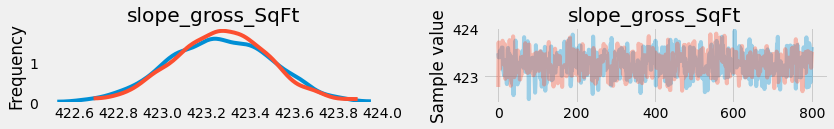

<Figure size 720x720 with 0 Axes>

In [66]:
fig = pm.traceplot(trace[199:1000])
plt.figure(figsize = (10, 10))

In [67]:
# posterior estimation with MCMC sampling

with pm.Model() as normal_model:
    
    # The prior for the model parameters
    slope_gross = pm.Normal('slope_gross_SqFt', mu = 150, sd = 50) 
    slope_land = pm.Normal('slope_land_SqFt', mu = 250, sd = 50) 
    slope_year = pm.Normal('slope_year', mu = 100, sd = 20) 

    sigma = 8000
    
    # Creating the model requires a formula and data (and optionally a family)
    mean = slope_gross * REsample1['gross_sq_feet'] + slope_land * REsample1['land_sq_feet'] + slope_year * REsample1['year_built']
    
    # Observed values
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = REsample1['sale_price'])
    
    # MCMC sampling
    # We use the Maximum a Posteriori (MAP) values as starting values for the MCMC sampling.
    start = pm.find_MAP()
    trace = pm.sample(1000, start=start, progressbar=True)

logp = -1.8777e+05, ||grad|| = 0.0073635: 100%|██████████| 12/12 [00:00<00:00, 660.71it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [slope_year, slope_land_SqFt, slope_gross_SqFt]
100%|██████████| 1500/1500 [00:03<00:00, 429.05it/s]


<Figure size 720x720 with 0 Axes>

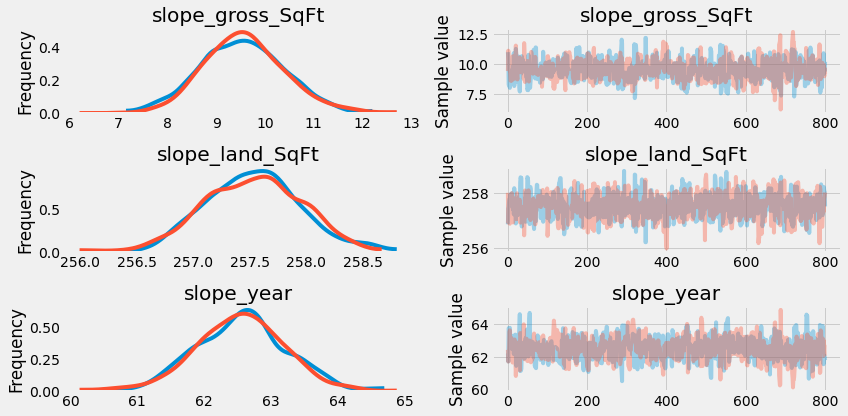

<Figure size 720x720 with 0 Axes>

In [68]:
fig = pm.traceplot(trace[199:1000])
plt.figure(figsize = (10, 10))

In [69]:
X = np.array(REsample1[['gross_sq_feet', 'land_sq_feet', 'year_built']])
y = np.array(REsample1[['sale_price']])
lr = sm.OLS(y, X).fit()

In [70]:
lr.params

array([  9.5360958 , 257.55486322,  62.52197887])